In [1]:
import pybaseball
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['text.usetex'] = True
plt.style.use('dark_background')

## Fitting Ballpark Data

Predicting the outcome of batted balls based on launch speed, launch angles, and ballpark.

In [2]:
stats_2022 = pybaseball.statcast('2022-01-01', '2022-12-31')
subset_2022 = stats_2022[stats_2022['hc_x'].notnull() & stats_2022['hc_x'].notnull() & stats_2022['launch_angle'].notnull() & stats_2022['launch_speed'].notnull()]
subset_2022["result"] = subset_2022.apply(lambda row: utils.EVENT_VALUE.get(row['events'], -1), axis=1)
subset_2022['horizontal_angle'] = subset_2022.apply(lambda row: utils.horizontal_angle(row['hc_x'], row['hc_y']), axis=1)
subset_2022 = subset_2022[['launch_angle', 'launch_speed', 'horizontal_angle', 'result', 'home_team']]
subset_2022

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [00:27<00:00,  8.92it/s]


,launch_angle,launch_speed,horizontal_angle,result,home_team
188,53,84.1,51.000493,-1,HOU
202,60,99.4,-39.587092,-1,HOU
210,14,105.8,-1.561369,1,HOU
217,44,82.2,22.901836,-1,HOU
142,43,88.9,-17.387021,-1,HOU
...,...,...,...,...,...
182,38,89.9,0.255234,-1,COL
360,5,108.4,-24.132217,1,COL
73,-15,86.9,-31.565517,-1,COL
124,-22,104.5,33.229834,-1,COL


In [3]:
# Get standard scalar for launch speed, vertical launch angle, and horizontal launch angle using all data
launch_speed = subset_2022['launch_speed'].to_numpy()
vertical_launch_angle = subset_2022['launch_angle'].to_numpy()
horizontal_launch_angle = subset_2022['horizontal_angle'].to_numpy()

'''
Create feature vector. Each feature is modelled with a polynomial.
The degree of each polynomial was chosen based on sample data shown in 'sample.ipynb'

launch speed - degree 3
vertical launch angle - degree 2
horizontal launch angle - degree 4
'''
num_features = 9
X = np.zeros((len(launch_speed), num_features))
X[:,0] = launch_speed
X[:,1] = launch_speed ** 2.0
X[:,2] = launch_speed ** 3.0
X[:,3] = vertical_launch_angle
X[:,4] = vertical_launch_angle ** 2.0
X[:,5] = horizontal_launch_angle
X[:,6] = horizontal_launch_angle ** 2.0
X[:,7] = horizontal_launch_angle ** 3.0
X[:,8] = horizontal_launch_angle ** 4.0
scaler = StandardScaler()
scalar = scaler.fit(X)

Fit linear logistic regression models on all batted balls separated by ballpark. The logistic regression model will predict the probability a batted ball is an out, single, double, triple, or home run. For each ballpark, the data is fit with L2 regularization coefficients ranging from 0.01 to 10000.0.

In [4]:
import warnings
warnings.filterwarnings("ignore") # ignore convergence warnings
model_by_team = dict()
alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
for team in utils.TEAMS:
    team_stats = subset_2022[subset_2022['home_team'] == team]
    launch_speed = team_stats['launch_speed'].to_numpy()
    vertical_launch_angle = team_stats['launch_angle'].to_numpy()
    horizontal_launch_angle = team_stats['horizontal_angle'].to_numpy()
    team_X = np.zeros((len(launch_speed), num_features))
    team_X[:,0] = launch_speed
    team_X[:,1] = launch_speed ** 2.0
    team_X[:,2] = launch_speed ** 3.0
    team_X[:,3] = vertical_launch_angle
    team_X[:,4] = vertical_launch_angle ** 2.0
    team_X[:,5] = horizontal_launch_angle
    team_X[:,6] = horizontal_launch_angle ** 2.0
    team_X[:,7] = horizontal_launch_angle ** 3.0
    team_X[:,8] = horizontal_launch_angle ** 4.0
    scaled_team_X = scaler.transform(team_X)
    team_Y = team_stats['result'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(scaled_team_X, team_Y, test_size=0.3)

    model_by_team[team] = dict()
    for alpha in alphas:
        logistic_regression = linear_model.LogisticRegression(C=alpha, multi_class='multinomial', max_iter=1000)
        logistic_regression.fit(X_train, y_train)
        score = logistic_regression.score(X_test, y_test)
        model_by_team[team][alpha] = dict()
        model_by_team[team][alpha]['score'] = score
        model_by_team[team][alpha]['clf'] = logistic_regression

To determine the ideal regularization coefficient, I have plotted a histogram indicating the regularization coefficient that resulted in the best accuracy predicting the test data at each MLB ballpark 30.

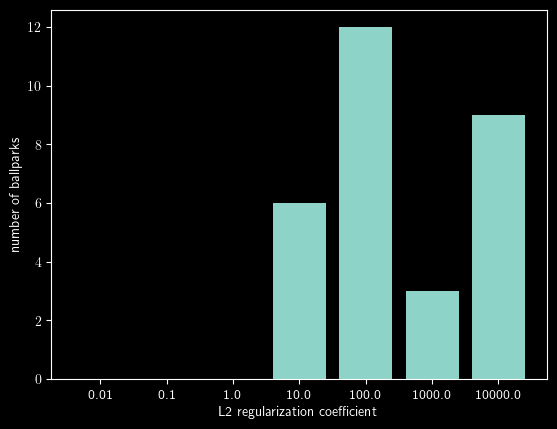

In [5]:
frequencies = np.zeros(len(alphas))
for team in model_by_team.keys():
    max_score = float('-inf')
    max_score_idx = -1
    for i, alpha in enumerate(alphas):
        if model_by_team[team][alpha]['score'] > max_score:
            max_score = model_by_team[team][alpha]['score']
            max_score_idx = i
    frequencies[max_score_idx] += 1

plt.bar(np.arange(len(alphas)), frequencies, tick_label=alphas)
plt.xlabel('L2 regularization coefficient')
plt.ylabel('number of ballparks')
plt.show()

Enter a launch speed, vertical launch angle, and horizontal launch angle below. Running the cell will compute the expected outcome of the batted ball in all 30 MLB ballparks using the models trained above. The expected value of the batted ball is computed using the following formula:

$\text{(expected value)} = P(\text{single}) + 2 * P(\text{double}) + 3 * P(\text{triple}) + 4 * P(\text{home run})$

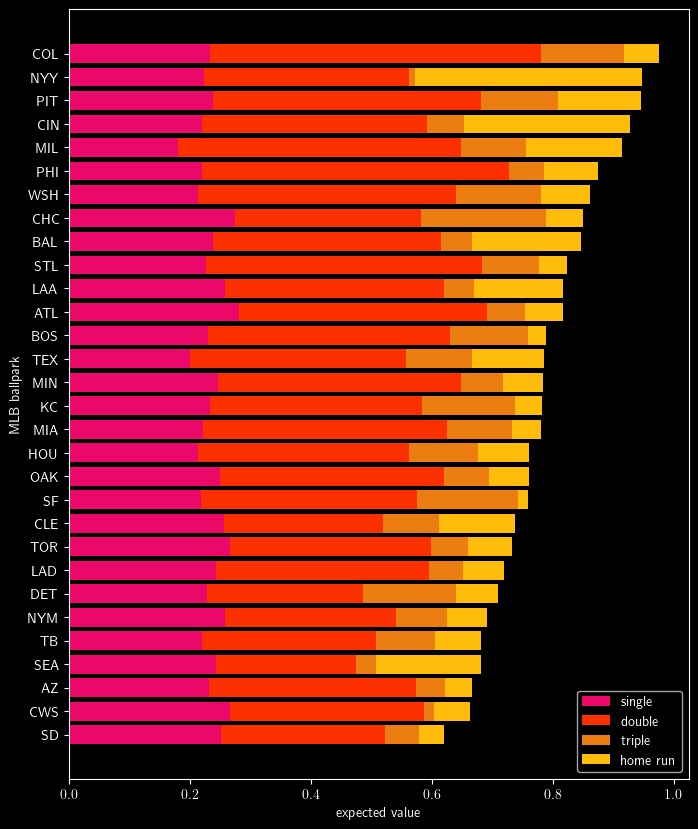

In [6]:
#######################################
####### ENTER TEST DATA HERE ##########
#######################################
test_launch_speed = 100.0
test_vertical_launch_angle = 20.0
test_horizontal_launch_angle = 25.0
#######################################

test_point = np.array([[
    test_launch_speed,
    test_launch_speed ** 2.0,
    test_launch_speed ** 3.0,
    test_vertical_launch_angle,
    test_vertical_launch_angle ** 2.0,
    test_horizontal_launch_angle,
    test_horizontal_launch_angle ** 2.0,
    test_horizontal_launch_angle ** 3.0,
    test_horizontal_launch_angle ** 4.0
]])
scaled_point = scalar.transform(test_point)

prb = np.zeros((30, 5))
teams = []
for idx, team in enumerate(utils.TEAMS):
    teams.append(team)
    clf = model_by_team[team][100.0]['clf']
    park_prb = clf.predict_proba(scaled_point)[0]
    prb[idx] = park_prb
zipped_results = zip(teams, prb)
sorted_results = sorted(zipped_results, key=lambda x: x[1][1] + 2.0 * x[1][2] + 3.0 * x[1][3] + 4.0 * x[1][4])

teams, park_prbs = list(zip(*sorted_results))
prb = np.array(park_prbs)

plt.figure(figsize=(8, 10))
plt.barh(teams, prb[:,1], color=utils.EVENT_COLOR['single'], label='single')
plt.barh(teams, prb[:,2]*2, left=prb[:,1], color=utils.EVENT_COLOR['double'], label='double')
plt.barh(teams, prb[:,3]*3, left=prb[:,1]+prb[:,2]*2, color=utils.EVENT_COLOR['triple'], label='triple')
plt.barh(teams, prb[:,4]*4, left=prb[:,1]+prb[:,2]*2+prb[:,3]*3, color=utils.EVENT_COLOR['home_run'], label='home run')
plt.legend()
plt.ylabel('MLB ballpark')
plt.xlabel('expected value')
plt.show()